In [1]:
%matplotlib inline

import math
import os

import biom
from gemelli.rpca import rpca
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgb
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from skbio.stats.distance import permanova
from statsmodels.stats.multitest import multipletests

plt.style.use("./paper.mplstyle")

data_dir = "../data/"

# Load Data

In [2]:
AZ20_table_filename = os.path.join(data_dir, "2022_09_29/AZ20_popcounts.biom")
AZ20_table = biom.load_table(AZ20_table_filename).to_dataframe(dense=True).T
print(AZ20_table.shape)
AZ20_table.iloc[:5, :5]

(70, 16012)


,menE_2~~~menE_1~~~menE,menC_2~~~menC_1~~~menC,hypA~~~hypB,group_678,hypD~~~hypC
23B_Day7,20.0,20.0,20.0,20.0,20.0
23B_Month3,24.0,24.0,24.0,24.0,24.0
23B_Month6,24.0,24.0,24.0,24.0,24.0
23LL_Day3,18.0,18.0,18.0,18.0,18.0
23LL_Day7,21.0,21.0,21.0,21.0,21.0


In [3]:
AZ51_table_filename = os.path.join(data_dir, "2022_09_29/AZ51_popcounts.biom")
AZ51_table = biom.load_table(AZ51_table_filename).to_dataframe(dense=True).T
print(AZ51_table.shape)
AZ51_table.iloc[:5, :5]

(82, 16211)


,group_928,ygbN_2~~~ygbN_1~~~ygbN,lpoA_2~~~lpoA_1~~~lpoA~~~lpoA_3,yidA,rluA_2~~~rluA~~~rluA_1
41B_Day7,24.0,24.0,24.0,24.0,24.0
41B_Month1,24.0,24.0,24.0,24.0,24.0
41B_Month3,23.0,23.0,23.0,23.0,23.0
41B_Month6,24.0,24.0,24.0,24.0,24.0
41LL_Day7,24.0,24.0,24.0,24.0,24.0


In [4]:
metadata = pd.read_table("../data/2022_09_29/collapsed_metadata.txt", sep="\t", index_col=0)
metadata.head()

,mouse,timepoint,cage_id,bacteria
sample-id,,,,
23B_Day7,23B,Day7,23,AZ20
23B_Month3,23B,Month3,23,AZ20
23B_Month6,23B,Month6,23,AZ20
23LL_Day3,23LL,Day3,23,AZ20
23LL_Day7,23LL,Day7,23,AZ20


In [5]:
AZ20_metadata = metadata[metadata["bacteria"] == "AZ20"].copy()
timepoints = ["Day3", "Day7", "Month1", "Month3", "Month6", "Month10"]
AZ20_metadata.loc[:, "timepoint"] = pd.Categorical(
    AZ20_metadata["timepoint"],
    categories=timepoints,
    ordered=True
)
print(AZ20_metadata.shape)
AZ20_metadata.iloc[:5, :5]

(70, 4)


,mouse,timepoint,cage_id,bacteria
sample-id,,,,
23B_Day7,23B,Day7,23,AZ20
23B_Month3,23B,Month3,23,AZ20
23B_Month6,23B,Month6,23,AZ20
23LL_Day3,23LL,Day3,23,AZ20
23LL_Day7,23LL,Day7,23,AZ20


In [6]:
AZ51_metadata = metadata[metadata["bacteria"] == "AZ51"].copy()
AZ51_metadata.loc[:, "timepoint"] = pd.Categorical(
    AZ51_metadata["timepoint"],
    categories=timepoints,
    ordered=True
)
print(AZ51_metadata.shape)
AZ51_metadata.iloc[:5, :5]

(82, 4)


,mouse,timepoint,cage_id,bacteria
sample-id,,,,
41B_Day7,41B,Day7,41,AZ51
41B_Month1,41B,Month1,41,AZ51
41B_Month3,41B,Month3,41,AZ51
41B_Month6,41B,Month6,41,AZ51
41LL_Day7,41LL,Day7,41,AZ51


In [7]:
class Dataset:
    def __init__(self, table: pd.DataFrame, metadata: pd.DataFrame, name: str):
        self.table = table
        self.name = name
        self.metadata = metadata
        
    def filter_data(self, min_prevalence=0.1, max_depth=600):
        # Filter out any genes that are present in fewer than 10% of samples
        gene_prevalence = self.table.clip(upper=1).sum(axis=0) / self.table.shape[0]
        genes_to_keep = gene_prevalence[gene_prevalence >= min_prevalence].index
        filt_table = self.table.loc[:, genes_to_keep]

        # Normalize by max isolates
        max_isolates = filt_table.max(axis=1)
        filt_table = filt_table.apply(lambda x: x/max_isolates, axis=0)

        # Filter out genes that are over 90% prevalence in at least 90% of samples
        overabund = (filt_table >= 0.9).sum()
        genes_to_keep = overabund[overabund <= int(0.9*filt_table.shape[0])].index
        filt_table = filt_table.loc[:, genes_to_keep]

        # Filter out any genes that have low abundance overall
        gene_sums = filt_table.sum(axis=0)
        genes_to_keep = gene_sums[gene_sums > 1].index
        filt_table = filt_table.loc[:, genes_to_keep]

        # Filter out samples that are too high
        samp_sums = filt_table.sum(axis=1)
        samps_to_keep = samp_sums[samp_sums <= max_depth].index
        filt_table = filt_table.loc[samps_to_keep, :]
        
        self.filt_table = filt_table
        self.metadata = self.metadata.loc[filt_table.index]
        print(f"Filtered table shape: ", self.filt_table.shape)
        
    def perform_rpca(self, n_components: int = 3):
        table = biom.Table(
            self.filt_table.T.values,
            observation_ids=self.filt_table.columns,
            sample_ids=self.filt_table.index
        )

        self.n_components = n_components
        self.ord_res, self.distance_matrix = rpca(table, n_components=n_components)
        self.pcs = list(self.ord_res.samples.columns)
        self.data = self.ord_res.samples.join(self.metadata)
    
    def plot_rpca(self, permutations: int = 999):
        fig, ax = plt.subplots(1, 1)

        sns.scatterplot(
            data=self.data,
            x="PC1",
            y="PC2",
            hue="timepoint",
            palette="plasma",
            edgecolor="black",
            linewidth=0.5,
            s=50,
            ax=ax
        )

        handles, labels = ax.get_legend_handles_labels()
        for h in handles:
            h.set_edgecolor("black")
            h.set_linewidth(0.5)

        ax.legend(
            handles=handles,
            ncol=1,
            loc="upper left",
            framealpha=1,
            edgecolor="black",
            title="Timepoint",
            bbox_to_anchor=[1, 1],
            fancybox=False
        )

        prop_1, prop_2 = self.ord_res.proportion_explained[:2].values
        ax.set_xlabel(f"PC1 ({prop_1*100:.2f}%)")
        ax.set_ylabel(f"PC2 ({prop_2*100:.2f}%)")
        
        pnova_res = permanova(self.distance_matrix, self.metadata, "timepoint",
                              permutations=permutations)
        f_stat = pnova_res["test statistic"]
        p_val = pnova_res["p-value"]
        
        ax.set_title(
            f"{self.name} RPCA (F = {f_stat:.2f}, p = {p_val:.2e})",
            loc="left",
            fontsize="large"
        )
        
    def plot_variance_explained(self):
        cumsum = self.ord_res.proportion_explained.cumsum()

        fig, ax = plt.subplots(1, 1)

        ax.plot(
            np.arange(len(cumsum)) + 1,
            cumsum,
            lw=2
        )

        ax.grid()
        ax.set_title(f"{self.name} RPCA")
        ax.set_xlabel("Principal Component"),
        ax.set_ylabel("Total Variance Explained")
        ax.set_xticks(np.arange(1, self.n_components + 1, 1))
    
    def get_timepoint_relationships(self):
        pvalues = []

        for pc in self.pcs:
            pvalues.append(ss.kruskal(
                *self.data.groupby("timepoint")[pc].apply(lambda x: x.values)
            ).pvalue)

        pvalues_corrected = multipletests(pvalues, method="fdr_bh")
        self.pvalues_corrected = pd.DataFrame(dict(
            uncorrected=pvalues,
            fdr_bh_corrected=pvalues_corrected[1],
            reject=pvalues_corrected[0]
        ), index=self.pcs)
        
    def plot_timepoint_relationships(self):
        sqrt = np.sqrt(self.n_components)
        fpart, ipart = math.modf(sqrt)
        if fpart > 0.5:
            nrow = int(ipart + 1)
            ncol = int(ipart + 1)
        else:
            nrow = int(ipart)
            ncol = int(ipart + 1)
            
        fig = plt.figure(figsize=(15, 15))
        
        alpha = 0.2
        color = list(to_rgb("gray")) + [alpha]

        for i, (pc, row) in enumerate(self.pvalues_corrected.iterrows()):
            ax = fig.add_subplot(nrow, ncol, i+1)
            
            args = dict(data=self.data, x="timepoint", y=pc, ax=ax)
            sns.lineplot(
                **args,
                color="gray",
                estimator=np.median,
                err_kws=dict(alpha=alpha)
            )
            sns.stripplot(
                **args,
                palette="plasma",
                linewidth=0.5,
            )

            ax.grid(which="both")
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.tick_params("x", width=0)
            ax.set_yticklabels([])
            ax.tick_params("y", width=0)

            title = f"{pc}, q = {row['fdr_bh_corrected']:.2e}"

            fontweight = "bold" if row["reject"] else None            
            ax.set_title(title, fontweight=fontweight, fontsize="large")

            ax.tick_params(axis="x", labelrotation=45)
            
            bottom_idx_start = (nrow - 1) * ncol
            if i < bottom_idx_start:
                ax.tick_params("x", width=0)
                ax.set_xticklabels([])
            
        plt.subplots_adjust(hspace=0.15, wspace=0.05)

# AZ20

In [8]:
AZ20 = Dataset(AZ20_table, AZ20_metadata, "AZ20")
AZ20.filter_data()

Filtered table shape:  (68, 4661)


/home/grahman/miniconda3/envs/e_coli_colonization/lib/python3.9/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


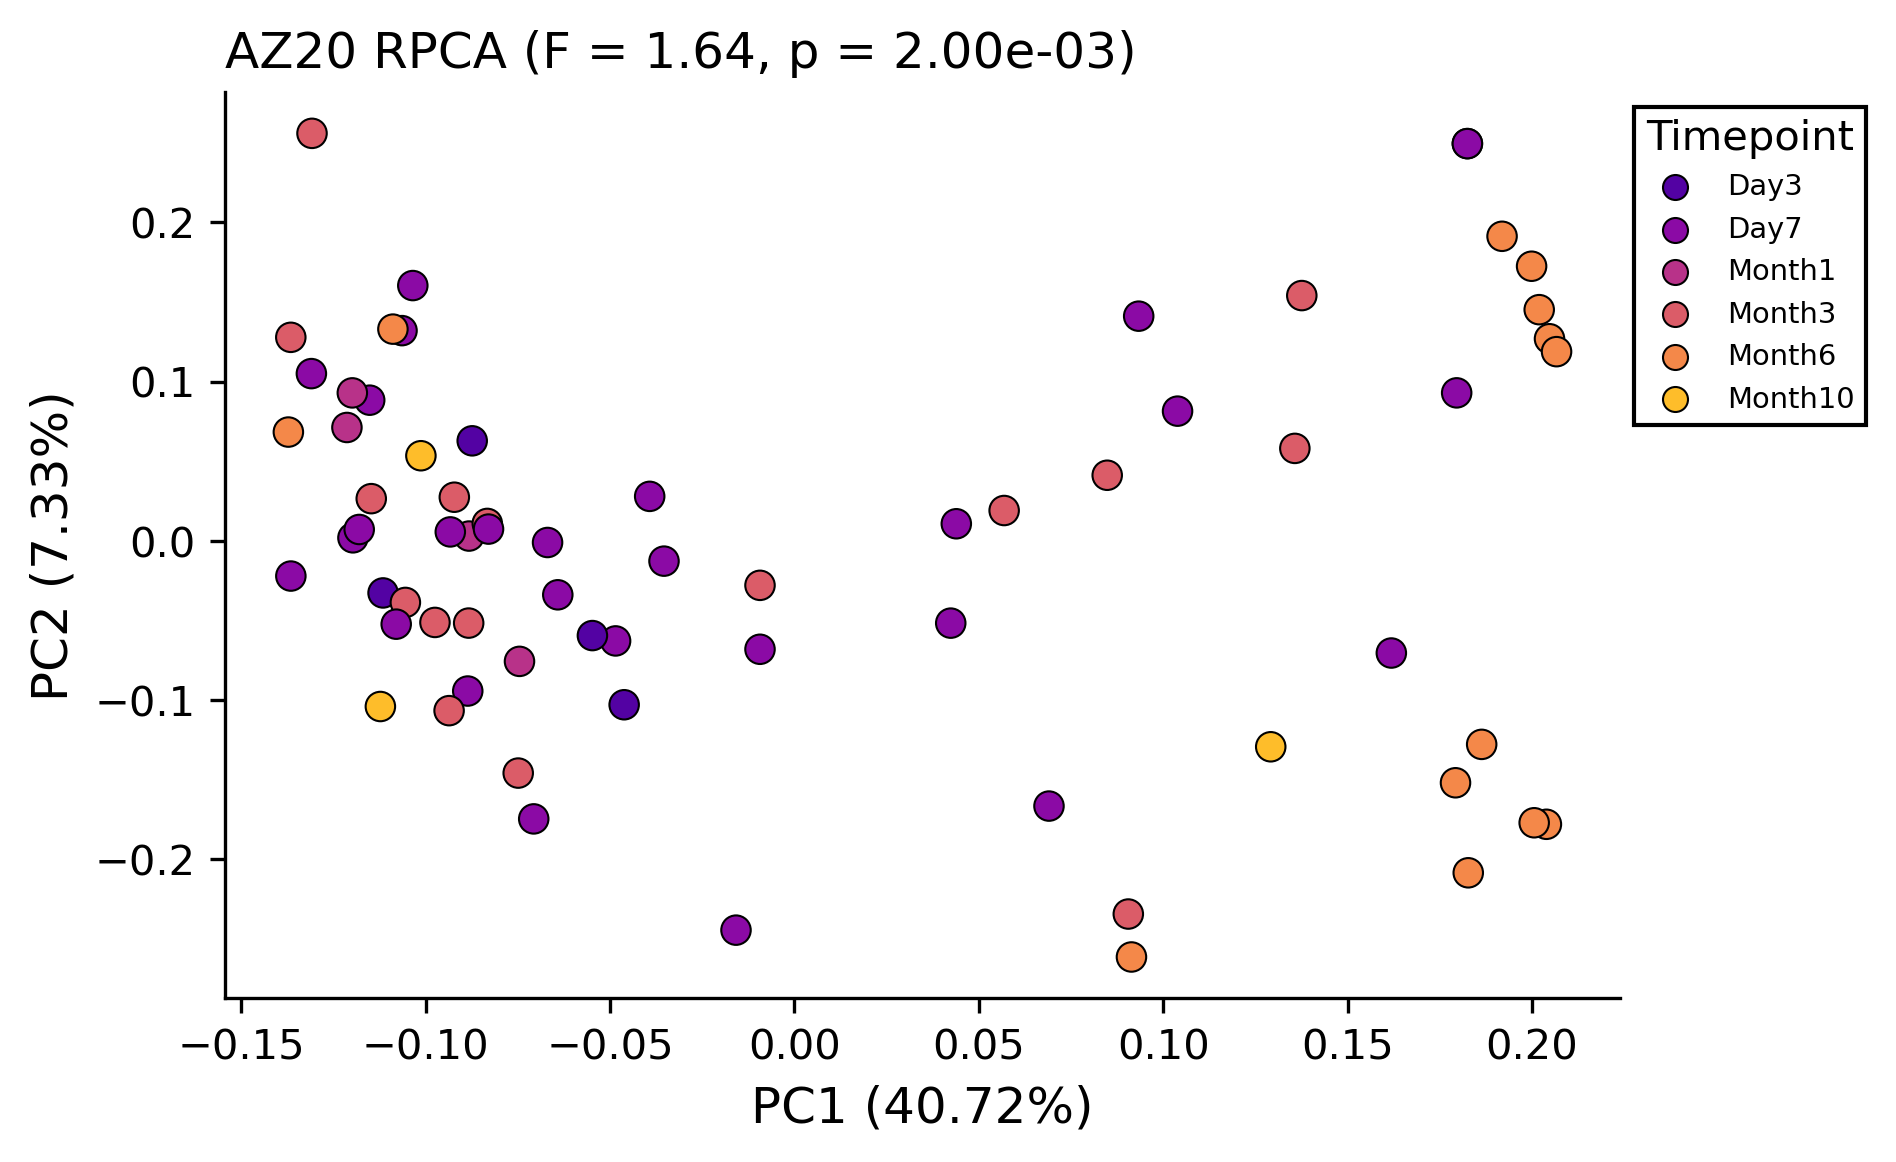

In [9]:
AZ20.perform_rpca(n_components=20)
AZ20.plot_rpca(permutations=5000)
plt.savefig("../figures/az20_rpca.svg")

In [10]:
permanova(AZ20.distance_matrix, AZ20.metadata, "mouse", permutations=5000)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      68
number of groups                 28
test statistic             0.707185
p-value                    0.979804
number of permutations         5000
Name: PERMANOVA results, dtype: object

In [11]:
permanova(AZ20.distance_matrix, AZ20.metadata, "cage_id", permutations=5000)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      68
number of groups                  8
test statistic             1.188121
p-value                    0.219756
number of permutations         5000
Name: PERMANOVA results, dtype: object

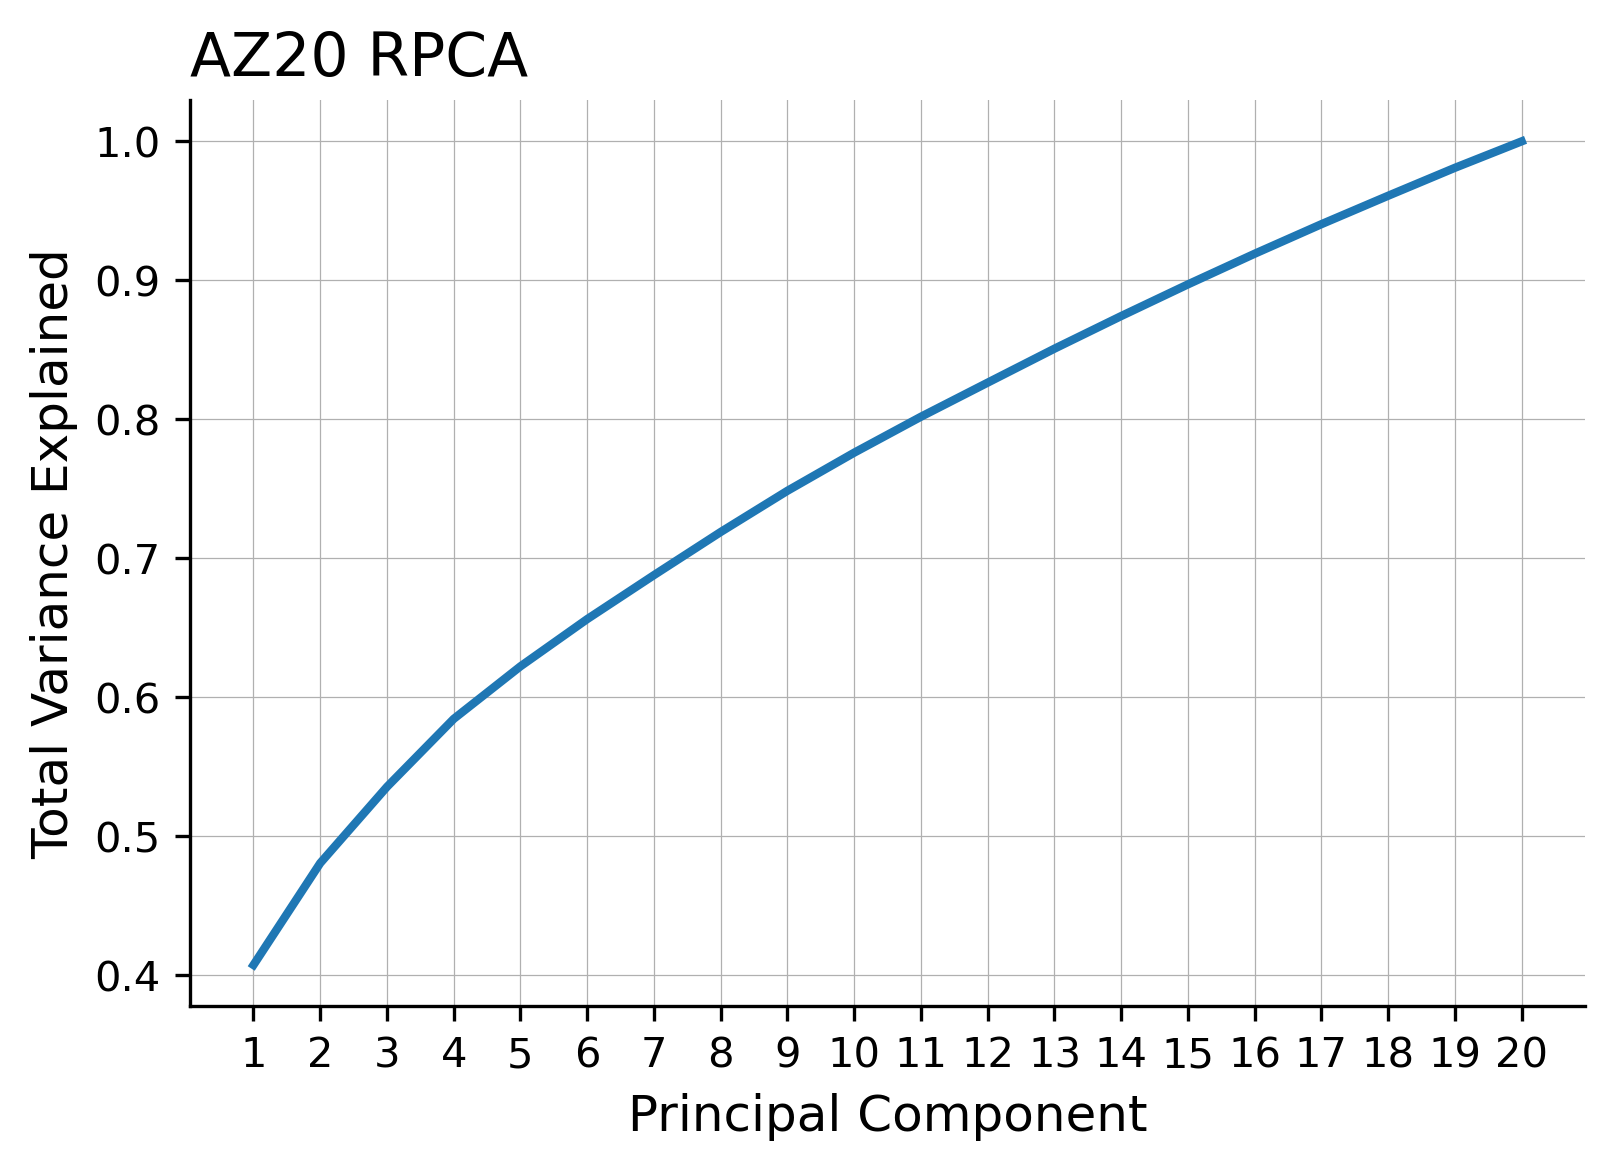

In [12]:
AZ20.plot_variance_explained()
plt.savefig("../figures/az20_rpca_cumulative_variance.svg")

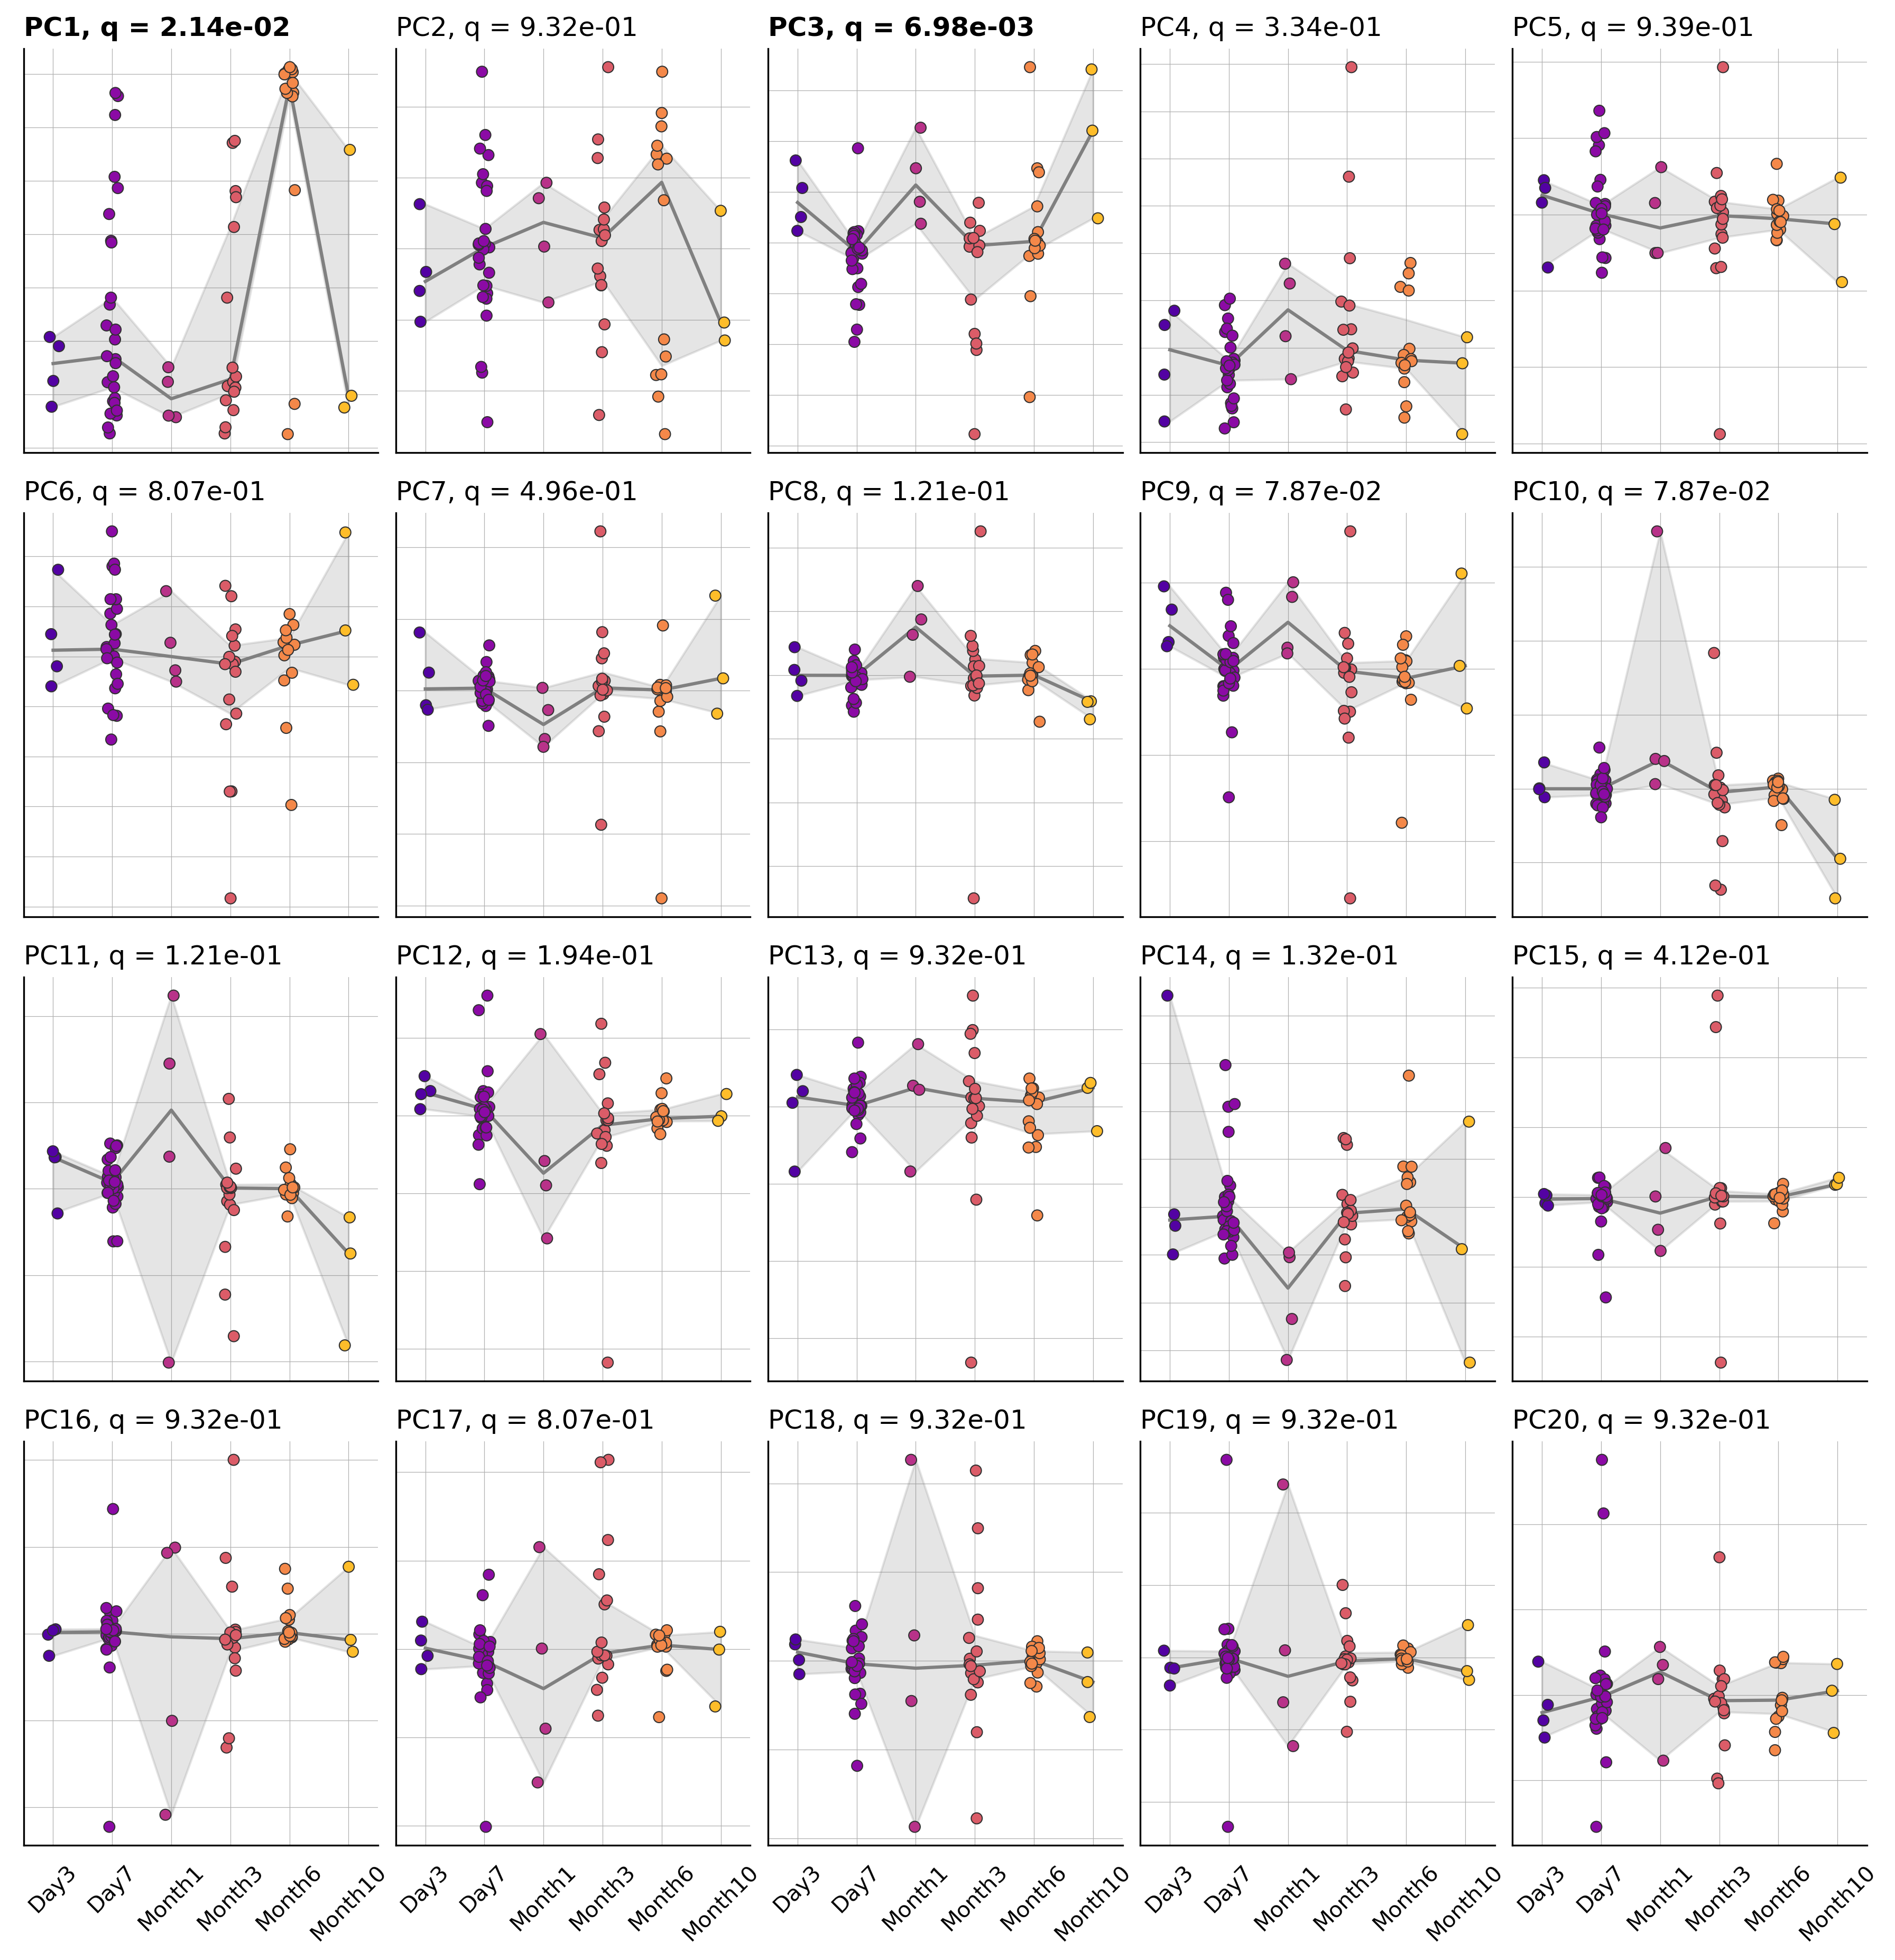

In [13]:
AZ20.get_timepoint_relationships()
AZ20.plot_timepoint_relationships()
plt.savefig("../figures/az20_pcs_timepoint.svg")

# AZ51

In [14]:
AZ51 = Dataset(AZ51_table, AZ51_metadata, "AZ51")
AZ51.filter_data()

Filtered table shape:  (71, 7936)


/home/grahman/miniconda3/envs/e_coli_colonization/lib/python3.9/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


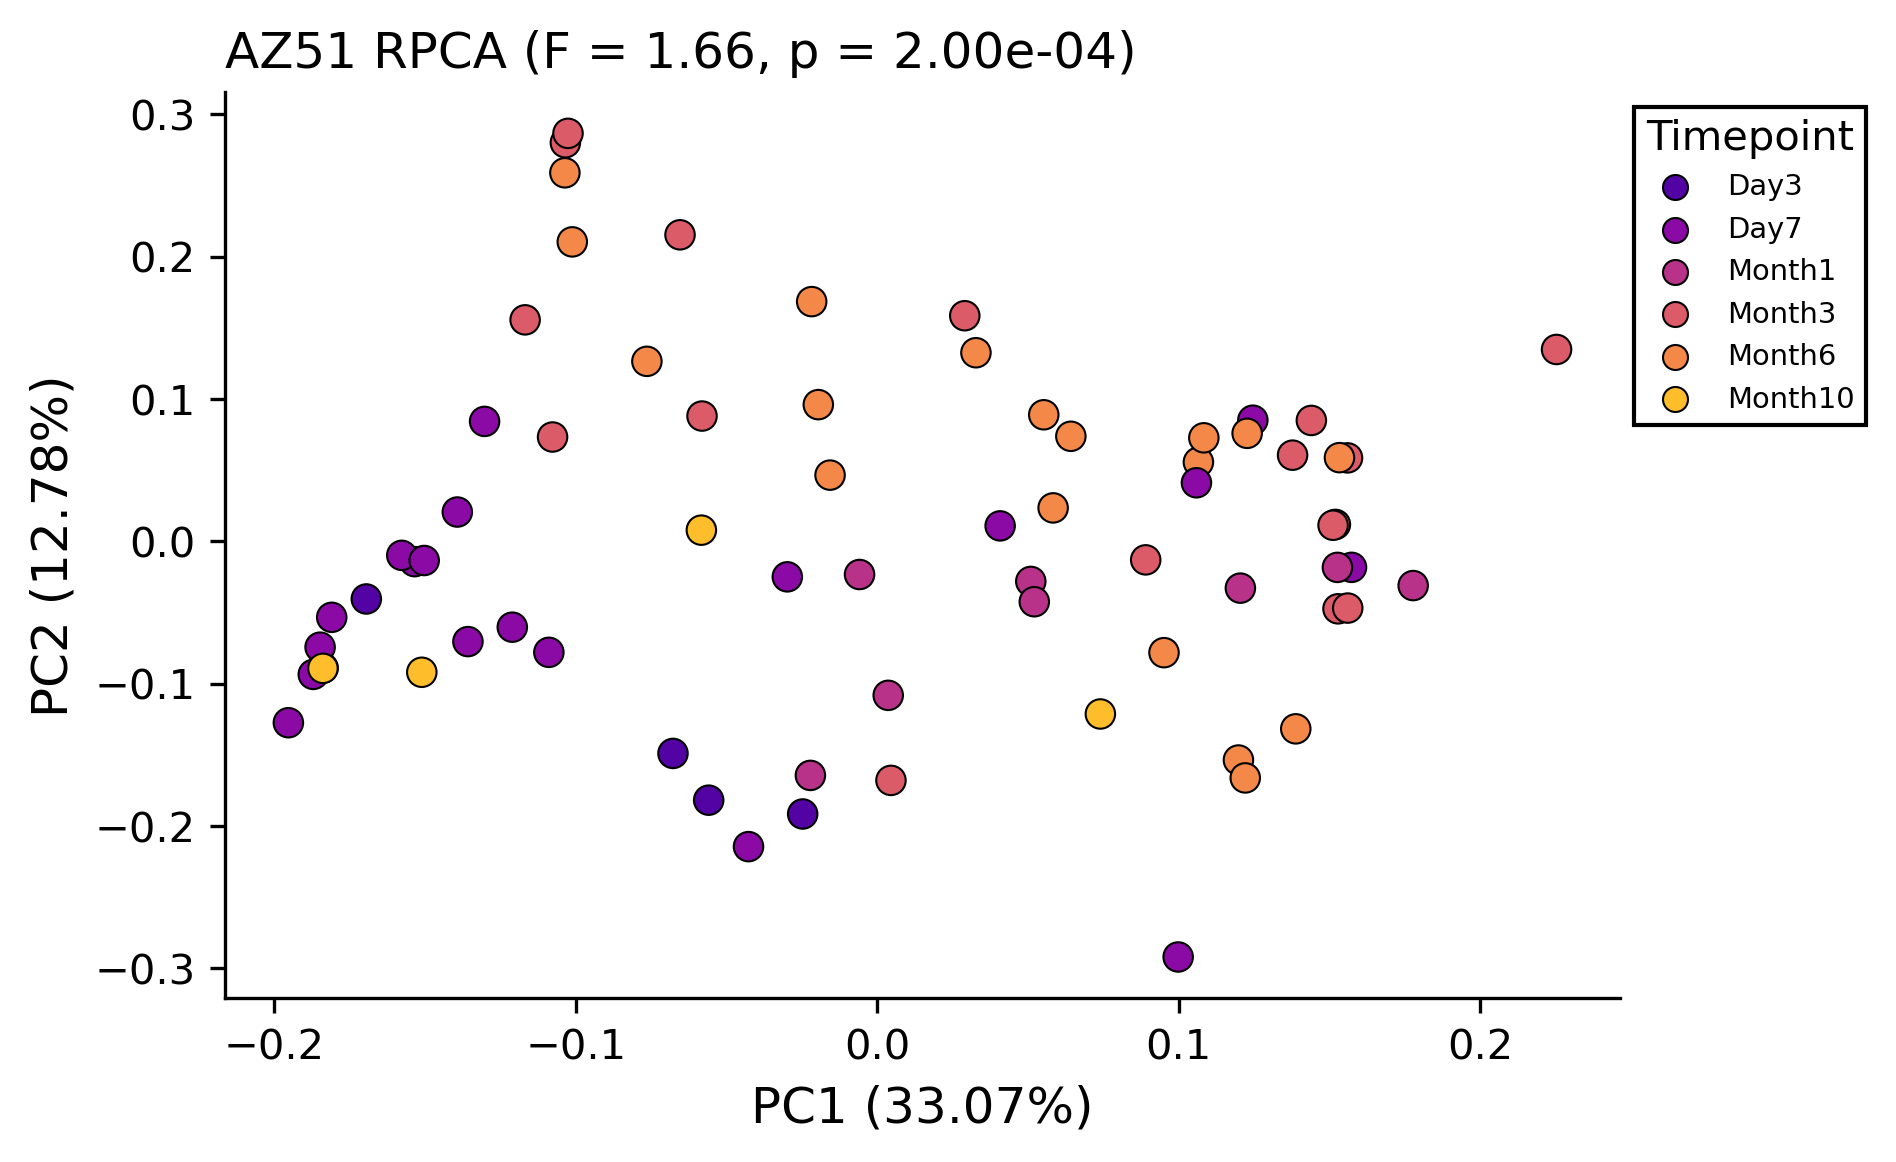

In [15]:
AZ51.perform_rpca(n_components=20)
AZ51.plot_rpca(permutations=5000)
plt.savefig("../figures/az51_rpca.svg")

In [16]:
permanova(AZ51.distance_matrix, AZ51.metadata, "mouse", permutations=5000)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      71
number of groups                 22
test statistic             1.004495
p-value                    0.467307
number of permutations         5000
Name: PERMANOVA results, dtype: object

In [17]:
permanova(AZ51.distance_matrix, AZ51.metadata, "cage_id", permutations=5000)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      71
number of groups                  6
test statistic             1.263332
p-value                    0.028194
number of permutations         5000
Name: PERMANOVA results, dtype: object

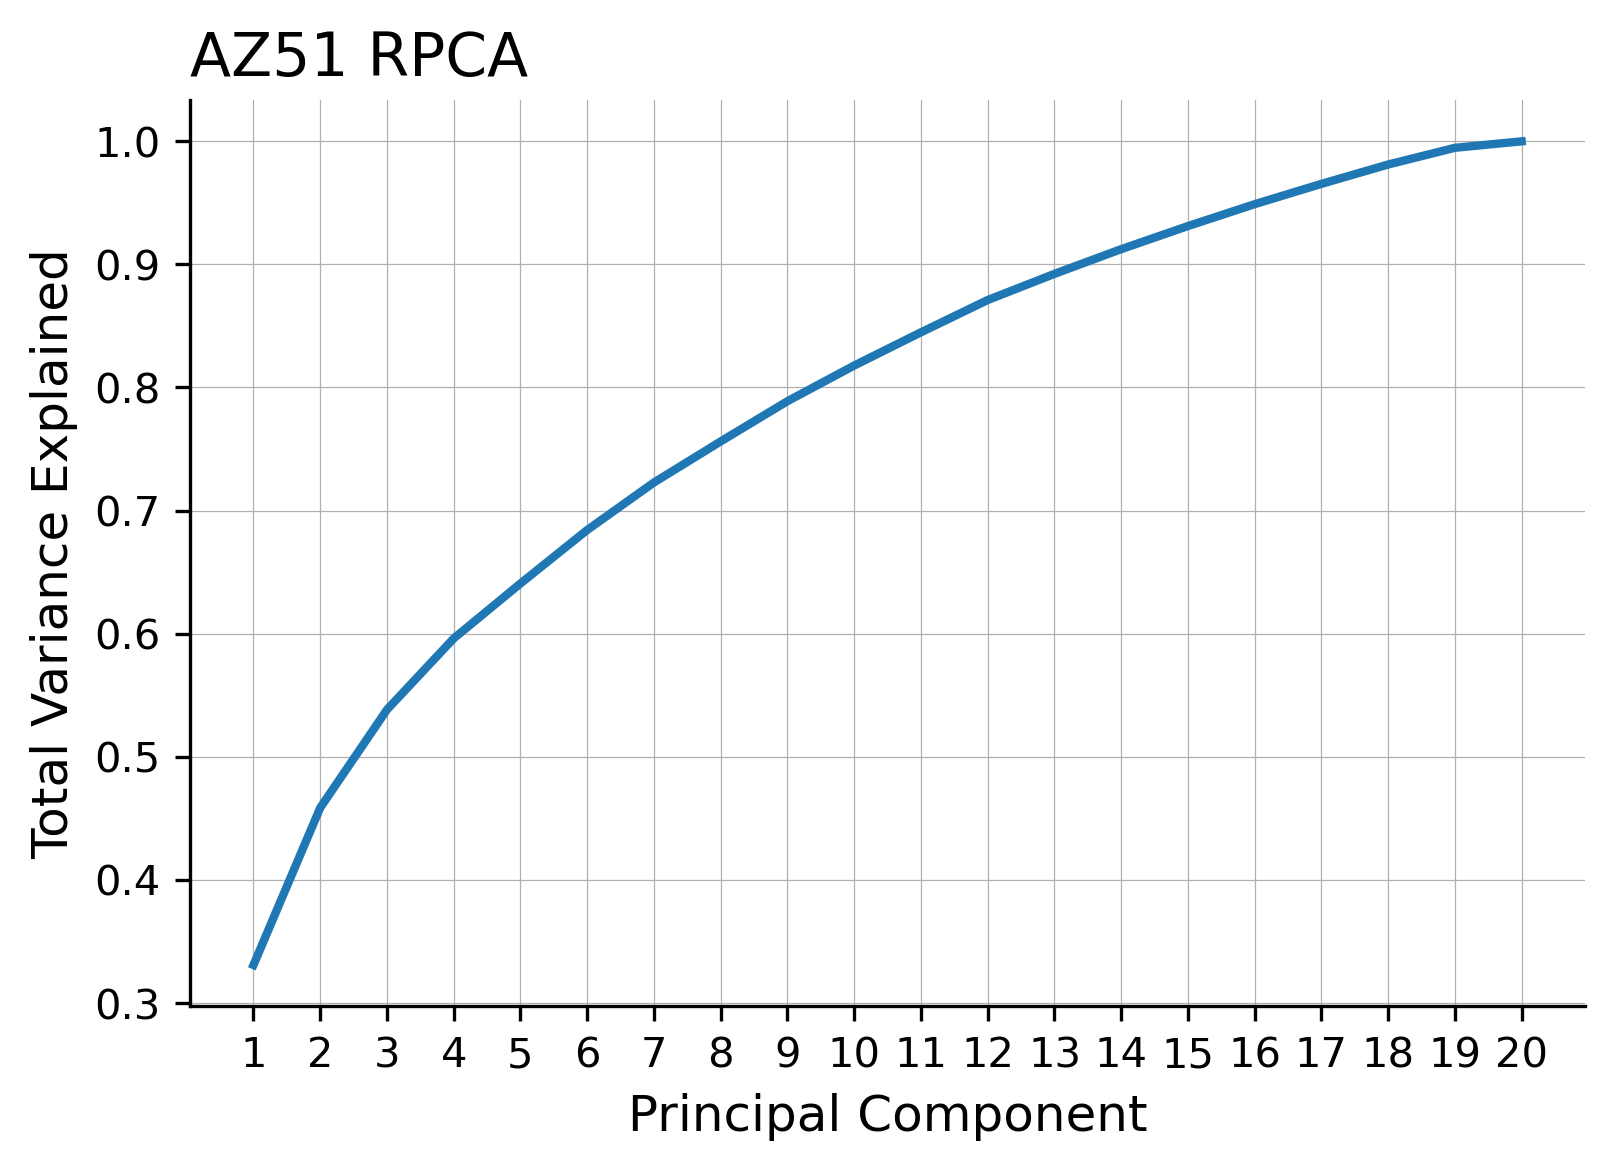

In [18]:
AZ51.plot_variance_explained()
plt.savefig("../figures/az51_rpca_cumulative_variance.svg")

In [ ]:
AZ51.get_timepoint_relationships()
AZ51.plot_timepoint_relationships()
plt.savefig("../figures/az51_pcs_timepoint.svg")

In [ ]:
AZ20.data.to_csv("../results/AZ20_pca.tsv", sep="\t", index=True)
AZ51.data.to_csv("../results/AZ51_pca.tsv", sep="\t", index=True)

In [ ]:
AZ20.ord_res.features.to_csv("../results/AZ20_pc_genes.tsv", sep="\t", index=True)
AZ51.ord_res.features.to_csv("../results/AZ51_pc_genes.tsv", sep="\t", index=True)

In [ ]:
from matplotlib.gridspec import GridSpec
from matplotlib import ticker

fig = plt.figure(figsize=(6, 6))
gs = GridSpec(ncols=1, nrows=2, hspace=0.1)

ax_box = fig.add_subplot(gs[1])
ax_var = fig.add_subplot(gs[0])

rng = np.random.default_rng(42)

comparisons = list(zip(timepoints[1:], timepoints))
dms = [AZ20.distance_matrix.to_data_frame(), AZ51.distance_matrix.to_data_frame()]
offset = 0.2
lw = 1.5
alpha = 0.2

AZ20_distances = []
AZ51_distances = []

AZ20_medians = []
AZ51_medians = []

AZ20_median_vars = []
AZ51_median_vars = []

AZ20_vars = []
AZ51_vars = []

for i, (c1, c2) in enumerate(comparisons):
    for dataset, dist_list, dm, _offset, color, medians, _vars in zip(
        [AZ20, AZ51],
        [AZ20_distances, AZ51_distances],
        dms,
        [-offset, offset],
        ["blue", "gold"],
        [AZ20_medians, AZ51_medians],
        [AZ20_vars, AZ51_vars]
    ):
        c1_idx = dataset.metadata.query("timepoint == @c1").index.tolist()
        c2_idx = dataset.metadata.query("timepoint == @c2").index.tolist()
        values = dm.loc[c1_idx, c2_idx].values.ravel()
        dist_list.append(values)
        
        color_alpha = list(to_rgb(color)) + [alpha]
        
        boxprops = {"facecolor": color_alpha, "linewidth": lw, "edgecolor": color}
        medianprops = {"color": color, "linewidth": lw, "zorder": 2}
        whiskerprops = {"color": color, "linewidth": lw}
        capprops = {"color": color, "linewidth": lw}
        flierprops = {"marker": "d", "markerfacecolor": color_alpha, "markeredgecolor": color,
                      "markersize": 5}
        
        bp = ax_box.boxplot(
            positions=[i + _offset],
            x=values,
            widths=0.35,
            patch_artist=True,
            boxprops=boxprops,
            medianprops=medianprops,
            capprops=capprops,
            whiskerprops=whiskerprops,
            flierprops=flierprops,
            showfliers=True,
        )
        
        medians.append(np.median(values))
        _vars.append(np.var(values))
        
        ax_var.bar(
            [i + _offset],
            np.var(values),
            width=0.35,
            facecolor=color_alpha,
            edgecolor=color,
            lw=lw
        )

xticks = np.arange(len(comparisons))
ax_box.set_xticks(xticks)
ax_box.set_xticklabels([" vs. ".join(c) for c in comparisons], rotation=45)

line_args = {"lw": 2, "zorder": 2}
scatter_args = {"s": 20, "zorder": 3, "linewidth": 1, "edgecolor": "black"}

ax_box.plot(xticks - offset, AZ20_medians, color="blue", **line_args)
ax_box.scatter(xticks - offset, AZ20_medians, color="blue", **scatter_args)

ax_box.plot(xticks + offset, AZ51_medians, color="gold", **line_args)
ax_box.scatter(xticks + offset, AZ51_medians, color="gold", **scatter_args)

ax_box.set_ylabel("RPCA Distances")
ax_box.tick_params("x", width=0)

AZ20_patch = Patch(facecolor=list(to_rgb("blue")) + [alpha], label="AZ20", linewidth=1, edgecolor="blue")
AZ51_patch = Patch(facecolor=list(to_rgb("gold")) + [alpha], label="AZ51", linewidth=1, edgecolor="gold")

ax_var.legend(
    handles=[AZ20_patch, AZ51_patch],
    loc="upper left",
    fancybox=False,
    edgecolor="black",
    framealpha=1,
)

ax_var.set_xlim(ax_box.get_xlim())
ax_var.set_xticklabels([])
ax_var.set_ylabel("Variances")

ax_var.plot(xticks - offset, AZ20_vars, color="blue", **line_args)
ax_var.scatter(xticks - offset, AZ20_vars, color="blue", **scatter_args)

ax_var.plot(xticks + offset, AZ51_vars, color="gold", **line_args)
ax_var.scatter(xticks + offset, AZ51_vars, color="gold", **scatter_args)
ax_var.tick_params("x", width=0)

ax_var_ylim = ax_var.get_ylim()
ax_var_yrange = ax_var_ylim[1]
ax_var.set_ylim((0, ax_var_yrange * (1 + 0.2)))

pad_pct = 0.1

for i, (_AZ20_var, _AZ51_var) in enumerate(zip(AZ20_vars, AZ51_vars)):
    new_AZ20_var = _AZ20_var + ax_var_yrange * pad_pct
    new_AZ51_var = _AZ51_var + ax_var_yrange * pad_pct
    max_var = max([new_AZ20_var, new_AZ51_var])
    args = {"color": "black", "zorder": 4}
    ax_var.plot(
        [xticks[i] - offset, xticks[i] + offset],
        [max_var] * 2,
        **args
    )
    
    bottom = max_var - ax_var_yrange * pad_pct / 5
    ax_var.plot(
        [xticks[i] - offset, xticks[i] - offset],
        [bottom, max_var],
        **args
    )
    ax_var.plot(
        [xticks[i] + offset, xticks[i] + offset],
        [bottom, max_var],
        **args
    )
    
    stat, pval = ss.levene(AZ20_distances[i], AZ51_distances[i], center="median")
    ax_var.text(
        x=i,
        y=max_var + 0.4,
        s=f"p = {pval:.2e}",
        va="bottom",
        ha="center",
        fontsize="x-small",
        bbox=dict(facecolor="wheat", boxstyle="round", linewidth=0.5)
    )
    
for ax in [ax_box, ax_var]:
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.grid(axis="x", which="minor", linewidth=0.1)
    ax.grid(axis="y", which="major", linewidth=0.1)
    ax.tick_params("x", width=0, which="both")

plt.savefig("../figures/az20_az51_distances_variances_timepoint.svg")
plt.show()